### Цель:
Сегментация объектов, расположенных на территории горнопромышленного комплекса в ДФО на основе спутниковых снимков Sentinel-2.

Предварительное тестирование будет проводиться на открытом наборе данных по метрике Intersection over Union (IoU) для каждого класса, а также по общей метрике mean IoU (mIoU). При расчете метрики класс фона исключается.

Обучающая выборка содержит:
- части спутниковых снимков размером 256x256 пикселей 
- маски (изображения с метками классов) объектов, представленных в таблице.

Каждый снимок состоит из 6 каналов: BLUE, GREEN, RED, NIR, SWIR1, SWIR2. 


Финальные метрики после обучения:
 - Train loss: 0.0315
 - Val   loss: 0.0884
 - Train mIoU(1,2): 0.9605
 - Val   mIoU(1,2): 0.9407
 - Train IoU per class: [C0=0.9781, C1=0.9522, C2=0.9510]
 - Val   IoU per class: [C0=0.9697, C1=0.9349, C2=0.9175]

In [ ]:
!pip install numpy 
!pip install rasterio  
!pip install matplotlib  
!pip install torch  
!pip install segmentation-models-pytorch  

!pip install tqdm

In [ ]:
import os
import functools
import glob
import json
from tqdm import tqdm

import numpy as np
import rasterio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

import functools
from torch.optim.lr_scheduler import CosineAnnealingLR

import random

import zipfile
from pathlib import Path

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

In [ ]:
DIR_DATASET = '/kaggle/input/train-data/train'

In [ ]:
IGNORE_INDEX = 255  
NUM_CLASSES  = 3

# класс датасета с преобразованием формата входных данных в удобный для модели вид
class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, channels=None, transform=None, return_paths=False):
        assert len(imgs) == len(masks)
        self.imgs = imgs
        self.masks = masks
    
        if channels is not None:
            channels = np.asarray(channels, dtype=int)
        self.channels = channels
        self.transform = transform
        self.return_paths = bool(return_paths)

    def __len__(self):
        return len(self.imgs)

    def _read_image(self, pth_tif):
        with rasterio.open(pth_tif) as f:
            img = f.read().astype(np.float32)
       
        np.nan_to_num(img, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    
        if self.channels is not None:
            # проверка границ
            assert self.channels.max() < img.shape[0], \
                f"channels содержит индекс {self.channels.max()}, но в изображении только {img.shape[0]} каналов"
            img = img[self.channels] 
        return img

    def _read_mask(self, pth_mask):
        with rasterio.open(pth_mask) as f:
            m = f.read(1).astype(np.int64)     

        
        valid = (m >= 0) & (m < NUM_CLASSES)
        out = np.full_like(m, IGNORE_INDEX, dtype=np.int64)
        out[valid] = m[valid]
        return out

    def __getitem__(self, i):
        img = self._read_image(self.imgs[i])   
        msk = self._read_mask(self.masks[i])   

        if self.transform is not None:
            
            img_hwc = np.transpose(img, (1, 2, 0))  
            sample = self.transform(image=img_hwc, mask=msk)

            
            img_t = sample["image"]
            msk_t = sample["mask"]

            if isinstance(img_t, np.ndarray):
              
                assert img_t.ndim == 3, f"Ожидался [H,W,C], получил shape={img_t.shape}"
                img = np.transpose(img_t, (2, 0, 1)).copy() 
                img = torch.from_numpy(img)
            else:
                img = img_t
                if img.ndim == 3 and img.shape[-1] in (1, 3, 6) and img.shape[0] not in (1, 3, 6):
                    
                    img = img.permute(2, 0, 1).contiguous()

            if isinstance(msk_t, np.ndarray):
                msk = torch.from_numpy(msk_t.copy())
            else:
                msk = msk_t
        else:
            img = torch.from_numpy(np.ascontiguousarray(img))
            msk = torch.from_numpy(np.ascontiguousarray(msk))

        img = img.to(torch.float32)   
        msk = msk.to(torch.long)     

        if self.return_paths:
            return img, msk, self.imgs[i], self.masks[i]
        return img, msk

In [ ]:
LST_CHANNELS = [0, 1, 2, 3, 4, 5] 
NUM_CHANNELS = len(LST_CHANNELS)
assert NUM_CHANNELS == 6, f"Ожидалось 6 каналов, получено {NUM_CHANNELS}"

TRAIN_IMAGES_PATH = '/kaggle/input/train-data/train/train/image'
TRAIN_MASKS_PATH  = '/kaggle/input/train-data/train/train/mask'
VAL_IMAGES_PATH   = '/kaggle/input/train-data/train/val/image'
VAL_MASKS_PATH    = '/kaggle/input/train-data/train/val/mask'

for p in [TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, VAL_IMAGES_PATH, VAL_MASKS_PATH]:
    assert os.path.isdir(p), f"Директория не найдена: {p}"

def list_tifs(folder):
    files = glob.glob(os.path.join(folder, "*.tif")) + glob.glob(os.path.join(folder, "*.tiff"))
    return [Path(x) for x in files]

def pair_by_stem(img_paths, mask_paths):
    img_map  = {p.stem: p for p in img_paths}
    mask_map = {p.stem: p for p in mask_paths}

    common = sorted(set(img_map.keys()) & set(mask_map.keys()))
    missing_img  = sorted(set(mask_map.keys()) - set(img_map.keys()))
    missing_mask = sorted(set(img_map.keys())  - set(mask_map.keys()))

    if missing_img:
        raise FileNotFoundError(f"Для {len(missing_img)} масок нет изображений. Примеры: {missing_img[:5]}")
    if missing_mask:
        raise FileNotFoundError(f"Для {len(missing_mask)} изображений нет масок. Примеры: {missing_mask[:5]}")

    imgs  = [str(img_map[k]) for k in common]
    masks = [str(mask_map[k]) for k in common]
    return imgs, masks

raw_train_imgs  = list_tifs(TRAIN_IMAGES_PATH)
raw_train_masks = list_tifs(TRAIN_MASKS_PATH)
raw_val_imgs    = list_tifs(VAL_IMAGES_PATH)
raw_val_masks   = list_tifs(VAL_MASKS_PATH)

LST_TRAIN_IMG, LST_TRAIN_MASK = pair_by_stem(raw_train_imgs, raw_train_masks)
LST_VAL_IMG,   LST_VAL_MASK   = pair_by_stem(raw_val_imgs,   raw_val_masks)


dataset_train = Dataset(
    imgs=LST_TRAIN_IMG,
    masks=LST_TRAIN_MASK,
    channels=LST_CHANNELS,
    transform=None,    
    return_paths=False
)

dataset_val = Dataset(
    imgs=LST_VAL_IMG,
    masks=LST_VAL_MASK,
    channels=LST_CHANNELS,
    transform=None,    
    return_paths=False
)

print(f"  - Train: {len(dataset_train)} примеров")
print(f"  - Validation: {len(dataset_val)} примеров")

train_img, train_mask = LST_TRAIN_IMG, LST_TRAIN_MASK
val_img,   val_mask   = LST_VAL_IMG,   LST_VAL_MASK

  - Train: 623 примеров
  - Validation: 133 примеров


In [ ]:
EPS = 1e-6
BATCH_SIZE = 15

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def calculate_class_pixels(mask_paths, num_classes=NUM_CLASSES):
    class_pixel_counts = np.zeros(num_classes, dtype=np.int64)

    if len(mask_paths) == 0:
        raise ValueError("Список путей к маскам пуст")

    print(f"Анализ распределения классов в {len(mask_paths)} масках...")
    for path in tqdm(mask_paths):
        with rasterio.open(path) as f:
            mask = f.read(1).astype(np.int64)  # [H,W]

        valid = (mask >= 0) & (mask < num_classes)
        if valid.any():
            counts = np.bincount(mask[valid].ravel(), minlength=num_classes)
            class_pixel_counts += counts

    return class_pixel_counts

def compute_class_weights(pixel_counts, num_classes=NUM_CLASSES, eps=EPS):
    total_pixels = int(np.asarray(pixel_counts, dtype=np.int64).sum())
    if total_pixels == 0:
        raise ValueError("total_pixels == 0 после фильтрации валидных классов.")

    class_frequencies = pixel_counts / max(total_pixels, 1)
    # 1/freq (+eps) — чтобы класс с нулевой частотой не дал бесконечный вес
    class_weights = 1.0 / (class_frequencies + eps)
    class_weights = class_weights / class_weights.sum() * num_classes
    return class_weights.astype(np.float32), total_pixels, class_frequencies

pixel_counts = calculate_class_pixels(LST_TRAIN_MASK, NUM_CLASSES)

print("\n Распределение пикселей по классам")
class_weights_np, total_pixels, class_freq = compute_class_weights(pixel_counts, NUM_CLASSES, EPS)
for i, count in enumerate(pixel_counts):
    percentage = (count / total_pixels) * 100 if total_pixels > 0 else 0.0
    print(f"Класс {i}: {count} пикселей ({percentage:.4f}%)")

print("\nРассчитанные веса для CrossEntropyLoss ")
for i, w in enumerate(class_weights_np):
    print(f"Класс {i}: вес {float(w):.4f}")

class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float32, device=DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=IGNORE_INDEX)

Анализ распределения классов в 623 масках...


100%|██████████| 623/623 [00:02<00:00, 275.33it/s]


 Распределение пикселей по классам
Класс 0: 26808156 пикселей (65.6597%)
Класс 1: 12211966 пикселей (29.9101%)
Класс 2: 1808806 пикселей (4.4302%)

Рассчитанные веса для CrossEntropyLoss 
Класс 0: вес 0.1665
Класс 1: вес 0.3656
Класс 2: вес 2.4679


In [ ]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,           
    pin_memory=True,
    num_workers=4,         
    drop_last=True         
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=False,          
    pin_memory=True,
    num_workers=4,
    drop_last=False         
)

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name='resnet50',
    encoder_weights=None,         
    in_channels=NUM_CHANNELS,     
    classes=NUM_CLASSES,
)
model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=IGNORE_INDEX)

@torch.no_grad()
def mean_iou(logits: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index: int = IGNORE_INDEX):
    pred = torch.argmax(logits, dim=1)  

    valid = (target >= 0) & (target < num_classes)
    if ignore_index is not None:
        valid = valid & (target != ignore_index)

    if valid.sum() == 0:
        return torch.tensor(0.0, device=logits.device), torch.zeros(num_classes, device=logits.device)

    t = target[valid].reshape(-1).to(torch.int64)
    p = pred[valid].reshape(-1).to(torch.int64)
    hist = torch.bincount(num_classes * t + p, minlength=num_classes * num_classes)
    hist = hist.reshape(num_classes, num_classes).to(torch.float32)

    inter = torch.diag(hist)                  
    gt_sum = hist.sum(dim=1)                 
    pr_sum = hist.sum(dim=0)                 
    union = gt_sum + pr_sum - inter

    iou_per_class = inter / (union + 1e-8)
   
    valid_cls = gt_sum > 0
    if valid_cls.any():
        miou = iou_per_class[valid_cls].mean()
    else:
        miou = torch.tensor(0.0, device=logits.device)

    return miou, iou_per_class

FN_ACC = functools.partial(mean_iou, num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX)

LR = 3e-4
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=1e-2,          
    betas=(0.9, 0.999)
)

NUM_EPOCHS = 60
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

print("Модель: Unet++(resnet50, 6ch, с нуля), Weighted CrossEntropy(ignore_index), AdamW + CosineAnnealingLR.")

Модель: Unet++(resnet50, 6ch, с нуля), Weighted CrossEntropy(ignore_index), AdamW + CosineAnnealingLR.


In [ ]:
def Trainer(
    model,
    num_classes,
    optimizer,
    loss_fn,
    acc_fn,                  
    epochs,
    data_tr,
    data_val,
    scheduler=None,
    use_amp=True,
    grad_clip=1.0,
    accumulate_steps=1,
    best_ckpt_path="best.pt",
):
    
    scaler = torch.amp.GradScaler("cuda", enabled=(use_amp and DEVICE.type == "cuda"))
    history = []
    best_val_miou = -1.0

    def _confusion_from_logits(logits, target, C, ignore_index=IGNORE_INDEX):
        with torch.no_grad():
            pred = torch.argmax(logits, dim=1) 
            valid = (target >= 0) & (target < C)
            if ignore_index is not None:
                valid = valid & (target != ignore_index)

            if valid.sum() == 0:
                return torch.zeros(C, C, device=logits.device, dtype=torch.float32), 0

            t = target[valid].reshape(-1).to(torch.int64)
            p = pred[valid].reshape(-1).to(torch.int64)
            hist = torch.bincount(C * t + p, minlength=C * C).reshape(C, C).to(torch.float32)
            return hist, int(valid.sum())

    def _fmt_per_class(vec):
        vals = [float(x) for x in vec.detach().cpu()]
        return ", ".join([f"C{i}:{v:.4f}" for i, v in enumerate(vals)])

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        train_hist_epoch = torch.zeros(num_classes, num_classes, device=DEVICE, dtype=torch.float32)
        train_valid_pix = 0

        optimizer.zero_grad(set_to_none=True)
        stream = tqdm(data_tr, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)

        for step, (X_batch, Y_batch) in enumerate(stream, 1):
            X_batch = X_batch.to(DEVICE, non_blocking=True)
            Y_batch = Y_batch.to(DEVICE, non_blocking=True)

            with torch.amp.autocast("cuda", enabled=(use_amp and DEVICE.type == "cuda")):
                logits = model(X_batch)
                loss = loss_fn(logits, Y_batch)

            scaler.scale(loss).backward()

            if step % accumulate_steps == 0:
                if grad_clip and grad_clip > 0:
                    scaler.unscale_(optimizer)
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            running_train_loss += loss.item()

       
            avg_iou_batch, _ = acc_fn(logits, Y_batch)
            stream.set_postfix(
                Loss=f"{running_train_loss / step:.4f}",
                mIoU=f"{float(avg_iou_batch):.4f}"
            )

          
            hist_b, valid_pix_b = _confusion_from_logits(logits, Y_batch, num_classes)
            train_hist_epoch += hist_b
            train_valid_pix  += valid_pix_b

        inter = torch.diag(train_hist_epoch)
        gt_sum = train_hist_epoch.sum(dim=1)
        pr_sum = train_hist_epoch.sum(dim=0)
        union = gt_sum + pr_sum - inter
        train_iou_per_class = inter / (union + 1e-8)
        present_cls = gt_sum > 0
        train_miou = train_iou_per_class[present_cls].mean() if present_cls.any() \
                     else torch.tensor(0.0, device=DEVICE)

        model.eval()
        running_val_loss = 0.0
        val_hist_epoch = torch.zeros(num_classes, num_classes, device=DEVICE, dtype=torch.float32)
        val_valid_pix = 0

        with torch.no_grad():
            stream = tqdm(data_val, desc=f"Epoch {epoch + 1}/{epochs} [Valid]", leave=False)
            for step, (X_val, Y_val) in enumerate(stream, 1):
                X_val = X_val.to(DEVICE, non_blocking=True)
                Y_val = Y_val.to(DEVICE, non_blocking=True)

                with torch.amp.autocast("cuda", enabled=(use_amp and DEVICE.type == "cuda")):
                    Y_hat = model(X_val)
                    loss  = loss_fn(Y_hat, Y_val)

                running_val_loss += loss.item()

                avg_iou_batch, _ = acc_fn(Y_hat, Y_val)
                stream.set_postfix(
                    Loss=f"{running_val_loss / step:.4f}",
                    mIoU=f"{float(avg_iou_batch):.4f}"
                )

                hist_b, valid_pix_b = _confusion_from_logits(Y_hat, Y_val, num_classes)
                val_hist_epoch += hist_b
                val_valid_pix  += valid_pix_b

        inter_v = torch.diag(val_hist_epoch)
        gt_sum_v = val_hist_epoch.sum(dim=1)
        pr_sum_v = val_hist_epoch.sum(dim=0)
        union_v = gt_sum_v + pr_sum_v - inter_v
        val_iou_per_class = inter_v / (union_v + 1e-8)
        present_cls_v = gt_sum_v > 0
        val_miou = val_iou_per_class[present_cls_v].mean() if present_cls_v.any() \
                   else torch.tensor(0.0, device=DEVICE)


        lr = optimizer.param_groups[0]["lr"]
        epoch_rec = {
            "epoch": epoch + 1,
            "lr": lr,
            "train_loss": running_train_loss / max(len(data_tr), 1),
            "train_miou": float(train_miou),
            "train_iou_per_class": train_iou_per_class.detach().cpu().tolist(),
            "train_valid_pixels": int(train_valid_pix),
            "val_loss": running_val_loss / max(len(data_val), 1),
            "val_miou": float(val_miou),
            "val_iou_per_class": val_iou_per_class.detach().cpu().tolist(),
            "val_valid_pixels": int(val_valid_pix),
        }
        history.append(epoch_rec)

        print(
            f"[Per-class IoU] "
            f"Train: [{_fmt_per_class(train_iou_per_class)}] | "
            f"Val:   [{_fmt_per_class(val_iou_per_class)}]"
        )

        if scheduler is not None:
            scheduler.step()

        if float(val_miou) > best_val_miou:
            best_val_miou = float(val_miou)
            if best_ckpt_path:
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state": model.state_dict(),
                        "optimizer_state": optimizer.state_dict(),
                        "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
                        "val_miou": best_val_miou,
                        "class_iou": val_iou_per_class.detach().cpu().tolist(),
                    },
                    best_ckpt_path,
                )

      
        print(
            f"Epoch {epoch + 1}/{epochs} | "
            f"LR {lr:.2e} | "
            f"Train: loss {epoch_rec['train_loss']:.4f}, mIoU {epoch_rec['train_miou']:.4f} | "
            f"Val: loss {epoch_rec['val_loss']:.4f}, mIoU {epoch_rec['val_miou']:.4f}"
        )

    return history

In [ ]:
def reset_module(m):
    if hasattr(m, 'reset_parameters') and callable(m.reset_parameters):
        m.reset_parameters()

model.apply(reset_module)
print("Параметры модели сброшены")

Параметры модели сброшены


In [ ]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def _auto_num_workers():
    try:
        cpu = os.cpu_count() or 2
    except:
        cpu = 2
    return min(4, max(2, cpu // 2))

NUM_WORKERS = _auto_num_workers()

dataloader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=NUM_WORKERS,
    drop_last=True,                
    persistent_workers=NUM_WORKERS > 0,
    prefetch_factor=2 if NUM_WORKERS > 0 else None
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=NUM_WORKERS,
    drop_last=False,
    persistent_workers=NUM_WORKERS > 0,
    prefetch_factor=2 if NUM_WORKERS > 0 else None
)

NUM_EPOCHS = 60
DIR_SAVE = "/kaggle/working"
os.makedirs(DIR_SAVE, exist_ok=True)
BEST_CKPT = os.path.join(DIR_SAVE, "best.pt")

history = Trainer(
    model=model,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    loss_fn=loss_fn,
    acc_fn=FN_ACC,                
    epochs=NUM_EPOCHS,
    data_tr=dataloader_train,
    data_val=dataloader_val,
    scheduler=(scheduler if "scheduler" in globals() and scheduler is not None else None),
    best_ckpt_path=BEST_CKPT,
    use_amp=True,                  
    grad_clip=1.0,                
    accumulate_steps=1
)

torch.save(model.state_dict(), os.path.join(DIR_SAVE, "model_final_weights.pth"))

with open(os.path.join(DIR_SAVE, "history.json"), "w") as f:
    json.dump(history, f, indent=2)

print(f"Обучение завершено.\n"
      f"- Лучшая модель по val mIoU: {BEST_CKPT}\n"
      f"- Финальные веса: {os.path.join(DIR_SAVE, 'model_final_weights.pth')}\n"
      f"- История: {os.path.join(DIR_SAVE, 'history.json')}")

[Per-class IoU] Train: [C0:0.8045, C1:0.6697, C2:0.2836] | Val:   [C0:0.7765, C1:0.4948, C2:0.0503]
Epoch 1/60 | LR 3.00e-04 | Train: loss 0.6107, mIoU 0.5860 | Val: loss 0.8373, mIoU 0.4405


[Per-class IoU] Train: [C0:0.8748, C1:0.7262, C2:0.4605] | Val:   [C0:0.8670, C1:0.6620, C2:0.3382]
Epoch 2/60 | LR 3.00e-04 | Train: loss 0.3989, mIoU 0.6872 | Val: loss 0.4567, mIoU 0.6224


[Per-class IoU] Train: [C0:0.8851, C1:0.7371, C2:0.5070] | Val:   [C0:0.8800, C1:0.4833, C2:0.2245]
Epoch 3/60 | LR 2.99e-04 | Train: loss 0.3601, mIoU 0.7097 | Val: loss 0.5160, mIoU 0.5293


[Per-class IoU] Train: [C0:0.8801, C1:0.7320, C2:0.5077] | Val:   [C0:0.8511, C1:0.7001, C2:0.4931]
Epoch 4/60 | LR 2.98e-04 | Train: loss 0.3278, mIoU 0.7066 | Val: loss 0.3291, mIoU 0.6815


[Per-class IoU] Train: [C0:0.8975, C1:0.7475, C2:0.4942] | Val:   [C0:0.8583, C1:0.7466, C2:0.5263]
Epoch 5/60 | LR 2.97e-04 | Train: loss 0.3003, mIoU 0.7131 | Val: loss 0.2862, mIoU 0.7104


[Per-class IoU] Train: [C0:0.9034, C1:0.7754, C2:0.5687] | Val:   [C0:0.8629, C1:0.7562, C2:0.6593]
Epoch 6/60 | LR 2.95e-04 | Train: loss 0.2763, mIoU 0.7492 | Val: loss 0.2679, mIoU 0.7595


[Per-class IoU] Train: [C0:0.9060, C1:0.7747, C2:0.5404] | Val:   [C0:0.8965, C1:0.7864, C2:0.6141]
Epoch 7/60 | LR 2.93e-04 | Train: loss 0.2701, mIoU 0.7404 | Val: loss 0.2370, mIoU 0.7656


[Per-class IoU] Train: [C0:0.9080, C1:0.7841, C2:0.5763] | Val:   [C0:0.8994, C1:0.7926, C2:0.6766]
Epoch 8/60 | LR 2.90e-04 | Train: loss 0.2521, mIoU 0.7561 | Val: loss 0.2200, mIoU 0.7895


[Per-class IoU] Train: [C0:0.8979, C1:0.7720, C2:0.5827] | Val:   [C0:0.8813, C1:0.7674, C2:0.5582]
Epoch 9/60 | LR 2.87e-04 | Train: loss 0.2696, mIoU 0.7508 | Val: loss 0.2372, mIoU 0.7356


[Per-class IoU] Train: [C0:0.9070, C1:0.7835, C2:0.5589] | Val:   [C0:0.8910, C1:0.7301, C2:0.4816]
Epoch 10/60 | LR 2.84e-04 | Train: loss 0.2738, mIoU 0.7498 | Val: loss 0.3050, mIoU 0.7009


[Per-class IoU] Train: [C0:0.9071, C1:0.7926, C2:0.6013] | Val:   [C0:0.8786, C1:0.7736, C2:0.7299]
Epoch 11/60 | LR 2.80e-04 | Train: loss 0.2387, mIoU 0.7670 | Val: loss 0.2389, mIoU 0.7940


[Per-class IoU] Train: [C0:0.9129, C1:0.8099, C2:0.6200] | Val:   [C0:0.8995, C1:0.7762, C2:0.6103]
Epoch 12/60 | LR 2.76e-04 | Train: loss 0.2068, mIoU 0.7809 | Val: loss 0.2132, mIoU 0.7620


[Per-class IoU] Train: [C0:0.9164, C1:0.8215, C2:0.7023] | Val:   [C0:0.9168, C1:0.8198, C2:0.7532]
Epoch 13/60 | LR 2.71e-04 | Train: loss 0.1846, mIoU 0.8134 | Val: loss 0.1929, mIoU 0.8300


[Per-class IoU] Train: [C0:0.9202, C1:0.8224, C2:0.6895] | Val:   [C0:0.9016, C1:0.8093, C2:0.7588]
Epoch 14/60 | LR 2.67e-04 | Train: loss 0.2059, mIoU 0.8107 | Val: loss 0.2082, mIoU 0.8233


[Per-class IoU] Train: [C0:0.9167, C1:0.8114, C2:0.6075] | Val:   [C0:0.9005, C1:0.7959, C2:0.6946]
Epoch 15/60 | LR 2.62e-04 | Train: loss 0.2068, mIoU 0.7785 | Val: loss 0.1980, mIoU 0.7970


[Per-class IoU] Train: [C0:0.9128, C1:0.8147, C2:0.6912] | Val:   [C0:0.9047, C1:0.7982, C2:0.6187]
Epoch 16/60 | LR 2.56e-04 | Train: loss 0.1733, mIoU 0.8062 | Val: loss 0.1649, mIoU 0.7739


[Per-class IoU] Train: [C0:0.9182, C1:0.8305, C2:0.7318] | Val:   [C0:0.8943, C1:0.7993, C2:0.7940]
Epoch 17/60 | LR 2.51e-04 | Train: loss 0.1597, mIoU 0.8268 | Val: loss 0.1750, mIoU 0.8292


[Per-class IoU] Train: [C0:0.9210, C1:0.8364, C2:0.7394] | Val:   [C0:0.9071, C1:0.8063, C2:0.7204]
Epoch 18/60 | LR 2.45e-04 | Train: loss 0.1635, mIoU 0.8323 | Val: loss 0.1773, mIoU 0.8113


[Per-class IoU] Train: [C0:0.9258, C1:0.8450, C2:0.7541] | Val:   [C0:0.8963, C1:0.7788, C2:0.5849]
Epoch 19/60 | LR 2.38e-04 | Train: loss 0.1340, mIoU 0.8417 | Val: loss 0.2086, mIoU 0.7533


[Per-class IoU] Train: [C0:0.9236, C1:0.8417, C2:0.7504] | Val:   [C0:0.8790, C1:0.7156, C2:0.7690]
Epoch 20/60 | LR 2.32e-04 | Train: loss 0.1502, mIoU 0.8385 | Val: loss 0.3125, mIoU 0.7878


[Per-class IoU] Train: [C0:0.9239, C1:0.8447, C2:0.7532] | Val:   [C0:0.9033, C1:0.8167, C2:0.8100]
Epoch 21/60 | LR 2.25e-04 | Train: loss 0.1357, mIoU 0.8406 | Val: loss 0.1607, mIoU 0.8433


[Per-class IoU] Train: [C0:0.9285, C1:0.8515, C2:0.7843] | Val:   [C0:0.9180, C1:0.8415, C2:0.8159]
Epoch 22/60 | LR 2.18e-04 | Train: loss 0.1236, mIoU 0.8548 | Val: loss 0.1582, mIoU 0.8585


[Per-class IoU] Train: [C0:0.9321, C1:0.8618, C2:0.8146] | Val:   [C0:0.8983, C1:0.8093, C2:0.7641]
Epoch 23/60 | LR 2.11e-04 | Train: loss 0.1083, mIoU 0.8695 | Val: loss 0.1498, mIoU 0.8239


[Per-class IoU] Train: [C0:0.9332, C1:0.8649, C2:0.8105] | Val:   [C0:0.9278, C1:0.8483, C2:0.8366]
Epoch 24/60 | LR 2.04e-04 | Train: loss 0.1072, mIoU 0.8695 | Val: loss 0.1441, mIoU 0.8709


[Per-class IoU] Train: [C0:0.9335, C1:0.8614, C2:0.8135] | Val:   [C0:0.9061, C1:0.7922, C2:0.8374]
Epoch 25/60 | LR 1.97e-04 | Train: loss 0.1097, mIoU 0.8695 | Val: loss 0.2092, mIoU 0.8453


[Per-class IoU] Train: [C0:0.9378, C1:0.8736, C2:0.8214] | Val:   [C0:0.9192, C1:0.8416, C2:0.8040]
Epoch 26/60 | LR 1.89e-04 | Train: loss 0.1008, mIoU 0.8776 | Val: loss 0.1204, mIoU 0.8549


[Per-class IoU] Train: [C0:0.9374, C1:0.8717, C2:0.8291] | Val:   [C0:0.8949, C1:0.7640, C2:0.8461]
Epoch 27/60 | LR 1.82e-04 | Train: loss 0.0997, mIoU 0.8794 | Val: loss 0.2270, mIoU 0.8350


[Per-class IoU] Train: [C0:0.9381, C1:0.8715, C2:0.8231] | Val:   [C0:0.8960, C1:0.8075, C2:0.8065]
Epoch 28/60 | LR 1.74e-04 | Train: loss 0.1030, mIoU 0.8776 | Val: loss 0.1734, mIoU 0.8367


[Per-class IoU] Train: [C0:0.9404, C1:0.8784, C2:0.8391] | Val:   [C0:0.9222, C1:0.8480, C2:0.8555]
Epoch 29/60 | LR 1.66e-04 | Train: loss 0.0934, mIoU 0.8859 | Val: loss 0.1243, mIoU 0.8752


[Per-class IoU] Train: [C0:0.9456, C1:0.8889, C2:0.8617] | Val:   [C0:0.9275, C1:0.8565, C2:0.8455]
Epoch 30/60 | LR 1.58e-04 | Train: loss 0.0805, mIoU 0.8987 | Val: loss 0.1093, mIoU 0.8765


[Per-class IoU] Train: [C0:0.9451, C1:0.8876, C2:0.8706] | Val:   [C0:0.9400, C1:0.8733, C2:0.8411]
Epoch 31/60 | LR 1.50e-04 | Train: loss 0.0859, mIoU 0.9011 | Val: loss 0.1116, mIoU 0.8848


[Per-class IoU] Train: [C0:0.9488, C1:0.8915, C2:0.8826] | Val:   [C0:0.9390, C1:0.8767, C2:0.8559]
Epoch 32/60 | LR 1.43e-04 | Train: loss 0.0801, mIoU 0.9076 | Val: loss 0.0919, mIoU 0.8905


[Per-class IoU] Train: [C0:0.9498, C1:0.8964, C2:0.8816] | Val:   [C0:0.9440, C1:0.8819, C2:0.8427]
Epoch 33/60 | LR 1.35e-04 | Train: loss 0.0741, mIoU 0.9093 | Val: loss 0.1250, mIoU 0.8895


[Per-class IoU] Train: [C0:0.9520, C1:0.9015, C2:0.8882] | Val:   [C0:0.9435, C1:0.8843, C2:0.8819]
Epoch 34/60 | LR 1.27e-04 | Train: loss 0.0715, mIoU 0.9139 | Val: loss 0.1020, mIoU 0.9032


[Per-class IoU] Train: [C0:0.9546, C1:0.9052, C2:0.9018] | Val:   [C0:0.9448, C1:0.8883, C2:0.8933]
Epoch 35/60 | LR 1.19e-04 | Train: loss 0.0645, mIoU 0.9206 | Val: loss 0.0937, mIoU 0.9088


[Per-class IoU] Train: [C0:0.9546, C1:0.9048, C2:0.8988] | Val:   [C0:0.9512, C1:0.8938, C2:0.8947]
Epoch 36/60 | LR 1.12e-04 | Train: loss 0.0663, mIoU 0.9194 | Val: loss 0.1142, mIoU 0.9132


[Per-class IoU] Train: [C0:0.9553, C1:0.9073, C2:0.9064] | Val:   [C0:0.9514, C1:0.8976, C2:0.8900]
Epoch 37/60 | LR 1.04e-04 | Train: loss 0.0625, mIoU 0.9230 | Val: loss 0.0911, mIoU 0.9130


[Per-class IoU] Train: [C0:0.9612, C1:0.9184, C2:0.9190] | Val:   [C0:0.9558, C1:0.9076, C2:0.9037]
Epoch 38/60 | LR 9.69e-05 | Train: loss 0.0548, mIoU 0.9329 | Val: loss 0.0817, mIoU 0.9223


[Per-class IoU] Train: [C0:0.9626, C1:0.9212, C2:0.9158] | Val:   [C0:0.9532, C1:0.9019, C2:0.9032]
Epoch 39/60 | LR 8.97e-05 | Train: loss 0.0541, mIoU 0.9332 | Val: loss 0.0936, mIoU 0.9195


[Per-class IoU] Train: [C0:0.9643, C1:0.9238, C2:0.9285] | Val:   [C0:0.9513, C1:0.8983, C2:0.8776]
Epoch 40/60 | LR 8.26e-05 | Train: loss 0.0504, mIoU 0.9389 | Val: loss 0.0936, mIoU 0.9090


[Per-class IoU] Train: [C0:0.9651, C1:0.9254, C2:0.9297] | Val:   [C0:0.9587, C1:0.9121, C2:0.9047]
Epoch 41/60 | LR 7.58e-05 | Train: loss 0.0490, mIoU 0.9401 | Val: loss 0.0962, mIoU 0.9251


[Per-class IoU] Train: [C0:0.9667, C1:0.9295, C2:0.9257] | Val:   [C0:0.9617, C1:0.9149, C2:0.9044]
Epoch 42/60 | LR 6.91e-05 | Train: loss 0.0532, mIoU 0.9407 | Val: loss 0.0996, mIoU 0.9270


[Per-class IoU] Train: [C0:0.9688, C1:0.9326, C2:0.9332] | Val:   [C0:0.9638, C1:0.9214, C2:0.9101]
Epoch 43/60 | LR 6.26e-05 | Train: loss 0.0451, mIoU 0.9449 | Val: loss 0.0963, mIoU 0.9318


[Per-class IoU] Train: [C0:0.9694, C1:0.9339, C2:0.9353] | Val:   [C0:0.9625, C1:0.9202, C2:0.9031]
Epoch 44/60 | LR 5.64e-05 | Train: loss 0.0435, mIoU 0.9462 | Val: loss 0.0946, mIoU 0.9286


[Per-class IoU] Train: [C0:0.9710, C1:0.9370, C2:0.9382] | Val:   [C0:0.9532, C1:0.9030, C2:0.8989]
Epoch 45/60 | LR 5.05e-05 | Train: loss 0.0409, mIoU 0.9488 | Val: loss 0.0970, mIoU 0.9184


[Per-class IoU] Train: [C0:0.9715, C1:0.9386, C2:0.9424] | Val:   [C0:0.9623, C1:0.9196, C2:0.9016]
Epoch 46/60 | LR 4.48e-05 | Train: loss 0.0406, mIoU 0.9508 | Val: loss 0.0920, mIoU 0.9278


[Per-class IoU] Train: [C0:0.9727, C1:0.9409, C2:0.9397] | Val:   [C0:0.9612, C1:0.9180, C2:0.9047]
Epoch 47/60 | LR 3.94e-05 | Train: loss 0.0404, mIoU 0.9511 | Val: loss 0.1000, mIoU 0.9280


[Per-class IoU] Train: [C0:0.9732, C1:0.9423, C2:0.9424] | Val:   [C0:0.9673, C1:0.9290, C2:0.9039]
Epoch 48/60 | LR 3.43e-05 | Train: loss 0.0376, mIoU 0.9527 | Val: loss 0.0903, mIoU 0.9334


[Per-class IoU] Train: [C0:0.9740, C1:0.9439, C2:0.9433] | Val:   [C0:0.9662, C1:0.9275, C2:0.9147]
Epoch 49/60 | LR 2.96e-05 | Train: loss 0.0373, mIoU 0.9537 | Val: loss 0.0931, mIoU 0.9361


[Per-class IoU] Train: [C0:0.9758, C1:0.9474, C2:0.9455] | Val:   [C0:0.9680, C1:0.9310, C2:0.9181]
Epoch 50/60 | LR 2.51e-05 | Train: loss 0.0347, mIoU 0.9562 | Val: loss 0.0873, mIoU 0.9390


[Per-class IoU] Train: [C0:0.9759, C1:0.9477, C2:0.9484] | Val:   [C0:0.9666, C1:0.9286, C2:0.9150]
Epoch 51/60 | LR 2.10e-05 | Train: loss 0.0340, mIoU 0.9573 | Val: loss 0.0903, mIoU 0.9367


[Per-class IoU] Train: [C0:0.9763, C1:0.9490, C2:0.9473] | Val:   [C0:0.9685, C1:0.9319, C2:0.9176]
Epoch 52/60 | LR 1.73e-05 | Train: loss 0.0340, mIoU 0.9575 | Val: loss 0.0836, mIoU 0.9393


[Per-class IoU] Train: [C0:0.9764, C1:0.9489, C2:0.9490] | Val:   [C0:0.9689, C1:0.9327, C2:0.9198]
Epoch 53/60 | LR 1.39e-05 | Train: loss 0.0333, mIoU 0.9581 | Val: loss 0.0899, mIoU 0.9405


[Per-class IoU] Train: [C0:0.9772, C1:0.9506, C2:0.9473] | Val:   [C0:0.9690, C1:0.9340, C2:0.9157]
Epoch 54/60 | LR 1.09e-05 | Train: loss 0.0325, mIoU 0.9583 | Val: loss 0.0860, mIoU 0.9395


[Per-class IoU] Train: [C0:0.9773, C1:0.9507, C2:0.9504] | Val:   [C0:0.9690, C1:0.9334, C2:0.9177]
Epoch 55/60 | LR 8.32e-06 | Train: loss 0.0321, mIoU 0.9595 | Val: loss 0.0882, mIoU 0.9401


[Per-class IoU] Train: [C0:0.9772, C1:0.9507, C2:0.9510] | Val:   [C0:0.9691, C1:0.9337, C2:0.9181]
Epoch 56/60 | LR 6.09e-06 | Train: loss 0.0332, mIoU 0.9596 | Val: loss 0.0886, mIoU 0.9403


[Per-class IoU] Train: [C0:0.9776, C1:0.9517, C2:0.9500] | Val:   [C0:0.9690, C1:0.9339, C2:0.9155]
Epoch 57/60 | LR 4.27e-06 | Train: loss 0.0315, mIoU 0.9598 | Val: loss 0.0875, mIoU 0.9395


[Per-class IoU] Train: [C0:0.9776, C1:0.9513, C2:0.9493] | Val:   [C0:0.9687, C1:0.9334, C2:0.9148]
Epoch 58/60 | LR 2.84e-06 | Train: loss 0.0325, mIoU 0.9594 | Val: loss 0.0858, mIoU 0.9390


[Per-class IoU] Train: [C0:0.9779, C1:0.9520, C2:0.9513] | Val:   [C0:0.9688, C1:0.9332, C2:0.9193]
Epoch 59/60 | LR 1.82e-06 | Train: loss 0.0316, mIoU 0.9604 | Val: loss 0.0901, mIoU 0.9404


[Per-class IoU] Train: [C0:0.9781, C1:0.9522, C2:0.9510] | Val:   [C0:0.9697, C1:0.9349, C2:0.9175]
Epoch 60/60 | LR 1.20e-06 | Train: loss 0.0315, mIoU 0.9605 | Val: loss 0.0884, mIoU 0.9407
Обучение завершено.
- Лучшая модель по val mIoU: /kaggle/working/best.pt
- Финальные веса: /kaggle/working/model_final_weights.pth
- История: /kaggle/working/history.json


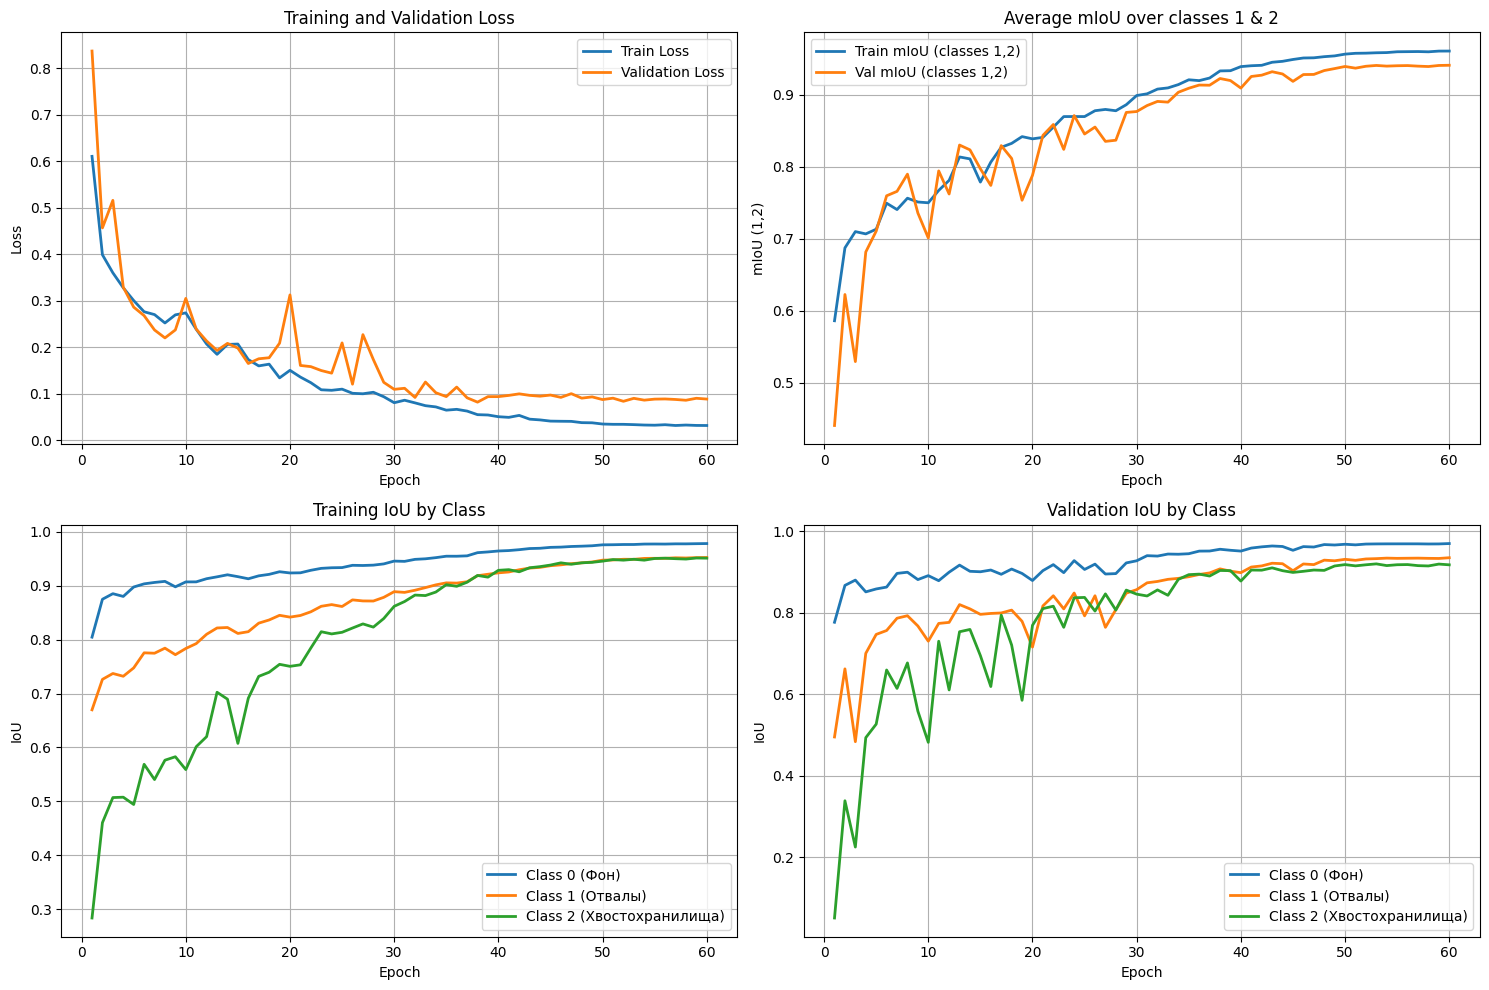

Финальные метрики после обучения:
 - Train loss: 0.0315
 - Val   loss: 0.0884
 - Train mIoU(1,2): 0.9605
 - Val   mIoU(1,2): 0.9407
 - Train IoU per class: [C0=0.9781, C1=0.9522, C2=0.9510]
 - Val   IoU per class: [C0=0.9697, C1=0.9349, C2=0.9175]


In [ ]:
if not history:
    print("История обучения пуста. Запустите обучение, чтобы сгенерировать данные для графиков.")
else:
    train_losses = [e.get("train_loss", np.nan) for e in history]
    val_losses   = [e.get("val_loss",   np.nan) for e in history]

    train_miou12 = [e.get("train_miou", np.nan) for e in history]
    val_miou12   = [e.get("val_miou",   np.nan) for e in history]

    def _safe_class(e, k, c, default=np.nan):
        v = e.get(k, None)
        if isinstance(v, (list, tuple)) and len(v) > c:
            return v[c]
        return default

    train_iou_0 = [_safe_class(e, "train_iou_per_class", 0) for e in history]
    train_iou_1 = [_safe_class(e, "train_iou_per_class", 1) for e in history]
    train_iou_2 = [_safe_class(e, "train_iou_per_class", 2) for e in history]

    val_iou_0 = [_safe_class(e, "val_iou_per_class", 0) for e in history]
    val_iou_1 = [_safe_class(e, "val_iou_per_class", 1) for e in history]
    val_iou_2 = [_safe_class(e, "val_iou_per_class", 2) for e in history]

    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss", linewidth=2)
    plt.plot(epochs_range, val_losses,   label="Validation Loss", linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
    plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_miou12, label="Train mIoU (classes 1,2)", linewidth=2)
    plt.plot(epochs_range, val_miou12,   label="Val mIoU (classes 1,2)",   linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('mIoU (1,2)'); plt.title('Average mIoU over classes 1 & 2')
    plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, train_iou_0, label="Class 0 (Фон)", linewidth=2)
    plt.plot(epochs_range, train_iou_1, label="Class 1 (Отвалы)", linewidth=2)
    plt.plot(epochs_range, train_iou_2, label="Class 2 (Хвостохранилища)", linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.title('Training IoU by Class')
    plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, val_iou_0, label="Class 0 (Фон)", linewidth=2)
    plt.plot(epochs_range, val_iou_1, label="Class 1 (Отвалы)", linewidth=2)
    plt.plot(epochs_range, val_iou_2, label="Class 2 (Хвостохранилища)", linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.title('Validation IoU by Class')
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("Финальные метрики после обучения:")
    print(f" - Train loss: {train_losses[-1]:.4f}")
    print(f" - Val   loss: {val_losses[-1]:.4f}")
    print(f" - Train mIoU(1,2): {train_miou12[-1]:.4f}")
    print(f" - Val   mIoU(1,2): {val_miou12[-1]:.4f}")
    print(f" - Train IoU per class: [C0={train_iou_0[-1]:.4f}, C1={train_iou_1[-1]:.4f}, C2={train_iou_2[-1]:.4f}]")
    print(f" - Val   IoU per class: [C0={val_iou_0[-1]:.4f}, C1={val_iou_1[-1]:.4f}, C2={val_iou_2[-1]:.4f}]")


In [ ]:
WEIGHTS_PATH = "/kaggle/working/model_final_weights.pth"
TEST_IMAGES_PATH = "/kaggle/input/test-open-dataset/test/image"

ROOT_OUT = "/kaggle/working"
DIR_OUT = os.path.join(ROOT_OUT, "segmentation_openset")  
os.makedirs(DIR_OUT, exist_ok=True)

state = torch.load(WEIGHTS_PATH, map_location=DEVICE)

model.load_state_dict(state)

model.eval()

def list_tifs(folder):
    return sorted(
        glob.glob(os.path.join(folder, "*.tif")) +
        glob.glob(os.path.join(folder, "*.tiff"))
    )

def read_image_as_tensor(pth_tif, channels_idx):
    with rasterio.open(pth_tif) as f:
        img = f.read().astype(np.float32) 
    np.nan_to_num(img, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    if channels_idx is not None:
        img = img[np.asarray(channels_idx, dtype=int)]
    return torch.from_numpy(img).unsqueeze(0) 

def ensure_256x256_label(arr_hw: np.ndarray) -> np.ndarray:
    h, w = arr_hw.shape
    if (h, w) == (256, 256):
        return arr_hw.astype(np.uint8, copy=False)
    import PIL.Image as PILImage
    im = PILImage.fromarray(arr_hw.astype(np.uint8), mode="L")
    im = im.resize((256, 256), resample=PILImage.NEAREST)
    return np.asarray(im, dtype=np.uint8)

def write_tiff_mask(path_tif: str, label_uint8_256: np.ndarray):
    meta = {
        "driver": "GTiff",
        "height": 256,
        "width": 256,
        "count": 1,
        "dtype": "uint8",
        "compress": "lzw",
        "nodata": None,
    }
    with rasterio.open(path_tif, "w", **meta) as dst:
        dst.write(label_uint8_256, 1)


test_imgs = list_tifs(TEST_IMAGES_PATH)
print(f"Найдено {len(test_imgs)} тестовых изображений.")

with torch.no_grad():
    for pth_img in tqdm(test_imgs, desc="Inference"):
        x = read_image_as_tensor(pth_img, LST_CHANNELS).to(DEVICE, non_blocking=True)
        logits = model(x)                       
        pred = torch.argmax(logits, dim=1)[0]     
        pred = pred.detach().cpu().numpy().astype(np.uint8)

        
        pred = ensure_256x256_label(pred)

       
        uniq = set(np.unique(pred).tolist())
        assert uniq.issubset({0, 1, 2, 3}), f"{Path(pth_img).name}: найдены недопустимые значения {uniq}"
        assert pred.dtype == np.uint8 and pred.shape == (256, 256)

        
        out_name = Path(pth_img).name
        out_path = os.path.join(DIR_OUT, out_name)
        write_tiff_mask(out_path, pred)

print(f"Маски сохранены в: {DIR_OUT}")

ZIP_PATH = os.path.join(ROOT_OUT, "submission.zip")
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in sorted(glob.glob(os.path.join(DIR_OUT, "*.tif")) +
                    glob.glob(os.path.join(DIR_OUT, "*.tiff"))):
        z.write(p, arcname=os.path.join("segmentation_openset", os.path.basename(p)))

print(f"Архив для отправки: {ZIP_PATH}")

Найдено 10 тестовых изображений.


Inference:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
Inference: 100%|██████████| 10/10 [00:00<00:00, 15.31it/s]

Маски сохранены в: /kaggle/working/segmentation_openset
Архив для отправки: /kaggle/working/submission.zip


In [ ]:
WEIGHTS_PATH = "/kaggle/working/model_final_weights.pth"
TEST_IMAGES_PATH = "/kaggle/input/final-data/final_test/image"

ROOT_OUT = "/kaggle/working"
DIR_OUT = os.path.join(ROOT_OUT, "segmentation_closedset_1")  
os.makedirs(DIR_OUT, exist_ok=True)

state = torch.load(WEIGHTS_PATH, map_location=DEVICE)

model.load_state_dict(state)

model.eval()

test_imgs = list_tifs(TEST_IMAGES_PATH)
print(f"Найдено {len(test_imgs)} тестовых изображений.")

with torch.no_grad():
    for pth_img in tqdm(test_imgs, desc="Inference"):
        x = read_image_as_tensor(pth_img, LST_CHANNELS).to(DEVICE, non_blocking=True)
        logits = model(x)                        
        pred = torch.argmax(logits, dim=1)[0]   
        pred = pred.detach().cpu().numpy().astype(np.uint8)
        
        pred = ensure_256x256_label(pred)

        uniq = set(np.unique(pred).tolist())
        assert uniq.issubset({0, 1, 2, 3}), f"{Path(pth_img).name}: найдены недопустимые значения {uniq}"
        assert pred.dtype == np.uint8 and pred.shape == (256, 256)

        out_name = Path(pth_img).name
        out_path = os.path.join(DIR_OUT, out_name)
        write_tiff_mask(out_path, pred)

print(f"Маски сохранены в: {DIR_OUT}")

ZIP_PATH = os.path.join(ROOT_OUT, "submission.zip")

with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in sorted(glob.glob(os.path.join(DIR_OUT, "*.tif")) +
                    glob.glob(os.path.join(DIR_OUT, "*.tiff"))):
        z.write(p, arcname=os.path.join("segmentation_closedset", os.path.basename(p)))

print(f"Архив для отправки: {ZIP_PATH}")

Найдено 133 тестовых изображений.


Inference: 100%|██████████| 133/133 [00:07<00:00, 17.08it/s]

Маски сохранены в: /kaggle/working/segmentation_closedset_1
Архив для отправки: /kaggle/working/submission.zip
